# Notebook for the blog Faster Forecasting using Ray AIR Distributed Computing

This notebook is to accompany blog "Faster Time Series Forecasting with Ray AIR".

**TODO add medium link once blog is published**


# Contents
 1. [Multi-model training using Ray core multiprocessing](#core_multiprocessing) 
 2. [Multi-model tuning using Ray Tune with Ray AIR](#tune_air)
 3. [Load a model from checkpoint](#restore_model)
 4. [Create a validation forecast from restored checkpoint model](#inference)
 5. [Deploy a batch predictor from checkpoint using Ray Serve](#serve_air)

## Multi-model training using Ray core multiprocessing <a class="anchor" id="core_multiprocessing"></a>

Import required libraries, including [Prophet](https://facebook.github.io/prophet/) and [Ray](https://towardsdatascience.com/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray-99f8d70369b8).

In [1]:
import time, dateutil
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
from typing import Tuple, List
import numpy as np
import pandas as pd
# Import libraries for reading from partitioned cloud storage paths.
import pyarrow.parquet as pq
import pyarrow.dataset as pds
# Import forecasting libraries.
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")
# Import Ray's multiprocessing library.
import ray
from ray.util.multiprocessing import Pool 
import tqdm

prophet: 1.0


/home/ray/anaconda3/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [27]:
# Define some global variables.
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/",
    partitioning=["month"],
)
S3_FILES = [f"s3://anonymous@{file}" for file in s3_partitions.files]
MIN_DATE = datetime(2018, 11, 1)
MAX_DATE = datetime(2019, 7, 30)
SAMPLE_UNIQUE_ID = 141
FORECAST_LENGTH = 28
TARGET = "trip_distance"

# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False

def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)

# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = False

# Use smoke testing or not.
models_to_train = S3_FILES[-1:] if SMOKE_TEST else S3_FILES

# Display what data will be used.
print(f"data files: {models_to_train}")


data files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/20

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-21 12:43:42,170	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-21 12:43:42,172	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 10.0.25.228:9031...
2023-01-21 12:43:42,180	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_zl6k8uzbges47yk66ufpvqtram/services?redirect_to=dashboard 


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://console.anyscale.com/api/v2/sessions/ses_zl6k8uzbges47yk66ufpvqtram/services?redirect_to=dashboard


In [4]:
print(ray.cluster_resources())

{'node:10.0.25.228': 1.0, 'memory': 18268483584.0, 'CPU': 8.0, 'object_store_memory': 9134241792.0}


In [28]:
##########
# STEP 1. Define Python functions to: 
# a) read and prepare a segment of data, and 
# b) train and evaluate a model on a segment of data.
##########
def prepare_data(file_path: str) -> Tuple[pd.DataFrame, np.int32]:
    """Read a S3 file, aggregate timestamp Daily level.
       Prophet requires timestamp is called 'ds' and target_value called 'y'.
       Prophet requires at least 2 data points per timestamp.
       StatsForecast requires taxi location is called 'unique_id'.

    Args:
        file_path (str): _description_

    Returns:
        Tuple[pd.DataFrame, np.int32]: _description_
    """
    
    # Read a single pyarrow parquet S3 file.
    data = pq.read_table(file_path,
                         filters=[ ("pickup_location_id", "=", SAMPLE_UNIQUE_ID) ],
                         columns=[ "pickup_at", "pickup_location_id", TARGET ],
                        ).to_pandas()
    
    # Transform data.
    data["ds"] = data["pickup_at"].dt.to_period("D").dt.to_timestamp()
    data.rename(columns={TARGET: "y"}, inplace=True)
    data.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    data.drop("pickup_at", inplace=True, axis=1)
    unique_id = data["unique_id"][0]
    return data, unique_id

def train_model(file_path: str) -> Tuple[pd.DataFrame, 
                                         pd.DataFrame, 
                                         'prophet.forecaster.Prophet', 
                                         np.int32]:
    
    # Prepare data from a single S3 file.
    data, unique_id = prepare_data(file_path)

    # Split data into train, test.
    train_end = data.ds.max() - relativedelta(days=FORECAST_LENGTH - 1)
    train_df = data.loc[(data.ds <= train_end), :].copy()
    test_df = data.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define Prophet model with 75% confidence interval.
    model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")      

    # Train and fit Prophet model.
    model = model.fit(train_df[["ds", "y"]])

    return train_df, test_df, model, unique_id

def evaluate_model(
    model: 'prophet.forecaster.Prophet',
    train: pd.DataFrame, 
    valid: pd.DataFrame,
    input_value: np.int32) -> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(
        periods=FORECAST_LENGTH, freq="D"
    )
    future = model.predict(future_dates)
    
    # Merge in the actual y-values.
    future = pd.merge(future, train[['ds', 'y']], on=['ds'], how='left')
    future = pd.merge(future, valid[['ds', 'y']], on=['ds'], how='left')
    future['y'] = future.y_x.combine_first(future.y_y)
    future.drop(['y_x', 'y_y'], inplace=True, axis=1)
    future['unique_id'] = input_value
    
    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
    temp.dropna(inplace=True)
    error = np.mean(temp["forecast_error"])

    return error, future

def train__and_evaluate(file_path: str) -> Tuple[pd.DataFrame, 
                                                 'prophet.forecaster.Prophet', 
                                                 pd.DataFrame, float, np.int16]:
    
    # Read S3 file and train a Prophet model.
    train_df, valid_df, model, unique_id = train_model(file_path)
    
    # Inference model and evaluate error.
    error, future = evaluate_model(model, train_df, valid_df, unique_id)
    
    return valid_df, model, future, error, unique_id

### Regular Python

In [6]:
start = time.time()

for file in models_to_train:
    print("Training model serially", file)
    test_df, model, forecast_df, error, unique_id = train__and_evaluate(file)
    print(test_df.shape, type(model), forecast_df.shape, type(error), type(unique_id))

time_regular_python = time.time() - start
print(f"Total number of models: {len(models_to_train)}")
print(f"TOTAL TIME TAKEN: {time_regular_python/60:.2f} minutes")

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Total number of models: 12
# TOTAL TIME TAKEN: 3.08 minutes


Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -48.6877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       66815.7   2.94776e-06       98.8241      0.4122           1       76   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(28, 3) <class 'prophet.forecaster.Prophet'> (27965, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet
(scheduler +7s) Failed to launch 1 node(s) of type worker-node-type-0.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -233.643
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        540798   0.000417077       2714.64      0.9406      0.9406      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        540804   9.75921e-05       795.191      0.8207      0.8207      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219        540804   0.000111432       213.624           1           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +45s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +45s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +45s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +45s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +45s) Failed to l

/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(scheduler +47s) Failed to launch 1 node(s) of type worker-node-type-0.
(28, 3) <class 'prophet.forecaster.Prophet'> (403287, 18) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -152.634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      30       72975.1   1.05928e-06       107.277      0.5061   0.0005061       67   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(28, 3) <class 'prophet.forecaster.Prophet'> (37260, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet
(scheduler +54s) Failed to launch 1 node(s) of type worker-node-type-0.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -37.4824
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      22       41025.6   1.38063e-05       90.2316   1.474e-07       0.001       82  LS failed, Hessian reset 
      27       41025.6   1.98004e-08       90.0563    0.009032           1      104   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(28, 3) <class 'prophet.forecaster.Prophet'> (17904, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(scheduler +59s) Failed to launch 1 node(s) of type worker-node-type-0.
Initial log joint probability = -9.08708
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      26       99729.3   3.96954e-05       91.2016           1           1       40   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(28, 3) <class 'prophet.forecaster.Prophet'> (29656, 15) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet
(scheduler +1m4s) Failed to launch 1 node(s) of type worker-node-type-0.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -345.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        492630   0.000119687       147.885      0.7907      0.7907      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        492630   0.000184327       288.965           1           1      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +1m32s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +1m32s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +1m32s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +1m32s) Failed to launch 1 node(s) of type worker-node-type-0.


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(scheduler +1m33s) Failed to launch 1 node(s) of type worker-node-type-0.
(28, 3) <class 'prophet.forecaster.Prophet'> (352262, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -160.107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36        476922   0.000417467       264.635           1           1       57   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +1m46s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +1m46s) Failed to launch 1 node(s) of type worker-node-type-0.


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(28, 3) <class 'prophet.forecaster.Prophet'> (340103, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/08/data.parquet/9d605bf8abf84655997d491bc5a10a4c_000000.parquet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(scheduler +1m49s) Failed to launch 1 node(s) of type worker-node-type-0.
Initial log joint probability = -164.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53        499170   0.000106452       156.696           1           1       91   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +2m5s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +2m5s) Failed to launch 1 node(s) of type worker-node-type-0.


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(28, 3) <class 'prophet.forecaster.Prophet'> (326291, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/09/data.parquet/b200f3d9bf9f485ebd3b20c0c08711e1_000000.parquet
(scheduler +2m7s) Failed to launch 1 node(s) of type worker-node-type-0.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1823.76
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        497591   7.45202e-05       204.764      0.6516      0.6516      108   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +2m29s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +2m29s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +2m29s) Failed to launch 1 node(s) of type worker-node-type-0.


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(scheduler +2m29s) Failed to launch 1 node(s) of type worker-node-type-0.
(28, 3) <class 'prophet.forecaster.Prophet'> (337053, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/10/data.parquet/20624e28db574114b47de3e43065f014_000000.parquet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -119.679
(scheduler +2m46s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +2m46s) Failed to launch 1 node(s) of type worker-node-type-0.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        154348    0.00175566       1147.84      0.6819      0.6819      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130        154348   5.21131e-06       121.709   2.589e-08       0.001      234  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(scheduler +2m48s) Failed to launch 1 node(s) of type worker-node-type-0.
(28, 3) <class 'prophet.forecaster.Prophet'> (65598, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/11/data.parquet/9c3fe546f3d746eeb3225b8150fb26e6_000000.parquet


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.4955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       85944.2   2.82334e-05       54.3035      0.6341      0.6341       81   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +2m52s) Failed to launch 1 node(s) of type worker-node-type-0.
(28, 3) <class 'prophet.forecaster.Prophet'> (28490, 15) <class 'numpy.float64'> <class 'numpy.int32'>
Training model serially s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/12/data.parquet/d9829239c5d34340a7d9ba256917ed98_000000.parquet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -25.9776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       98233.1   2.19309e-06       103.101   2.124e-08       0.001      137  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
(scheduler +3m0s) Failed to launch 1 node(s) of type worker-node-type-0.


/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ray/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(28, 3) <class 'prophet.forecaster.Prophet'> (34773, 21) <class 'numpy.float64'> <class 'numpy.int32'>
Total number of models: 12
TOTAL TIME TAKEN: 3.01 minutes


### Ray Multiprocessing

[Ray Multiprocessing](https://docs.ray.io/en/latest/ray-more-libs/multiprocessing.html) is easier to use than [Ray Core APIs](https://docs.ray.io/en/latest/ray-core/walkthrough.html).  Also, Ray Multiprocessing is more robust than regular [Python multiprocessing](https://docs.python.org/3/library/multiprocessing.html).

Below we run the regular Python functions, defined above, in a Ray Multiprocessing pool.

In [ ]:
# if ray.is_initialized():
#     ray.shutdown()
# # ray.init()

start = time.time()
# Create a pool, where each worker is assigned 1 CPU by Ray.
pool = Pool(ray_remote_args={"num_cpus": 1})

# Use the pool to run `train_model` on the data, in batches of 1.
iterator = pool.imap_unordered(train__and_evaluate, models_to_train, chunksize=1)

# Track the progress using tqdm and retrieve the results into a list.
results = list(tqdm.tqdm(iterator, total=len(models_to_train)))

time_ray_multiprocessing = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {time_ray_multiprocessing/60:.2f} minutes")

assert len(results) == len(models_to_train)
print(type(results[0][0]), type(results[0][1]), type(results[0][2]), 
      type(results[0][3]), type(results[0][4]))

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Chunksize=1
# Total number of models: 12
# TOTAL TIME TAKEN: 1.25 minutes


In [ ]:
# Calculate the speed-up between serial Python and Ray Multiprocessing Pool

speedup = time_regular_python / time_ray_multiprocessing
print(f"Speedup from running Ray Multiprocessing vs serial Python: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")

# Ran on my mac laptop with 8 CPU
# Speedup from running Ray Multiprocessing vs serial Python: 3.7x, or 300.0%

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Speedup from running Ray Multiprocessing vs serial Python: 2.5x, or 100.0%


## Multi-model training using Ray Tune with Ray AIR <a class="anchor" id="tune_air"></a>

The astute reader may have noticed, Approach 1 Ray Multiprocessing required the data to already be organized into 1 file per model you want to train. But what if your data isn't already organized by model? Ray AIR makes it easy to split up preparing data in the same pipeline while you are training different models. 

Another problem with Approach 1, what if you want to mix-and-match  more than 1 forecasting algorithm at a time? With Ray Tune, which is part of Ray AIR, you can run parallel trials to find the best choice of algorithm and hyperparameters, per segment of data. 

**With Ray AIR, any AI/ML Python library can be automatically tuned, and compared to each other, using distributed computing following the steps below.**

<ol>
    <li><b>Define Python functions</b>: 
    <ol>
        <li>Read and prepare a segment of data.
        <li>Train and evaluate a model on a segment of data.
    </ol>
    <li><b>Configure distributed compute <a href="https://docs.ray.io/en/master/train/config_guide.html">scaling</a></b>.
    <li><b>Define a Ray Tune search space</b> of all training parameters.
    <li>(Optional) Specify a hyperparameter search strategy.
    <li><b>Run the experiment</b> using Ray AIR APIs.
</ol>

Below is the additional code we would add.  Here is link to [Ray AIR documentation](https://docs.ray.io/en/latest/ray-air/getting-started.html).

In [8]:
import os
num_cpu = os.cpu_count()

print(f"num_cpus: {num_cpu}")
# Import another forecasting library.
import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")
# Import Ray AIR libraries.
from ray import air, tune
from ray.air import session, ScalingConfig
from ray.air.checkpoint import Checkpoint
RAY_IGNORE_UNHANDLED_ERRORS=1

num_cpus: 8
(scheduler +5m26s) Failed to launch 1 node(s) of type worker-node-type-0.
statsforecast: 1.3.1


In [9]:
# Obtain all location IDs
all_location_ids = (
    pq.read_table(S3_FILES[0], columns=["pickup_location_id"])[
        "pickup_location_id"
    ]
    .unique()
    .to_pylist()
)
all_location_ids.remove(264)
all_location_ids.remove(265)
all_location_ids.remove(199)
print(len(all_location_ids)) #256

# Use smoke testing or not.
files_to_use = S3_FILES[-1:] if SMOKE_TEST else S3_FILES
models_to_train = [173, 141] if SMOKE_TEST else all_location_ids[0:10] + [165, 237]
algorithms_to_use = ["prophet_additive"] if SMOKE_TEST \
    else ["prophet_additive", "prophet_multiplicative", "arima"]

# Display what data will be used.
print(f"files to use: {files_to_use}")
print(f"models to train: {models_to_train}")
print(f"algorithms to use: {algorithms_to_use}")

256
data files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_yea

In [10]:
##########
# STEP 1. Define Python functions to: 
# a) read and prepare a segment of data, and 
##########

# Function to read a pyarrow.Table object using pyarrow parquet
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">=", MIN_DATE),
            # ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df

# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    # StatsForecast requires location name is 'unique_id'

    # add year_month_day and concat into a unique column to use as groupby key
    df["ds"] = df["pickup_at"].dt.to_period("D").dt.to_timestamp()
    df["loc_year_month_day"] = (
        df["pickup_location_id"].astype(str)
        + "_"
        + df["pickup_at"].dt.year.astype(str)
        + "_"
        + df["pickup_at"].dt.month.astype(str)
        + "_"
        + df["pickup_at"].dt.day.astype(str)
    )
    # add target_value quantity for groupby count later
    df["y"] = 1
    # rename pickup_location_id to unique_id
    df.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    # keep only unnecessary columns
    df = df[['loc_year_month_day', 'unique_id', 'ds', 'y']].copy()

    # groupby aggregregate
    g = df.groupby("loc_year_month_day").agg(
        {"unique_id": min, "ds": min, "y": sum}
    )
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["y"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)

    return g

def prepare_data_per_uniqueid(
    s3_files: List[str], 
    sample_location_id: np.int32) -> pd.DataFrame:

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_location_id} has only {df_raw.shape[0]} rows"
        )
        session.report(dict(error=None))
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        session.report(dict(error=None))
        return None
    else:
        df.sort_values(by="ds", inplace=True)

    return df

In [11]:
##########
# STEP 1. Define Python functions to: 
# b) train and evaluate a model on a segment of data.
##########

# Function to train a Prophet model for a segment of data from list of files.
# This function is exactly the same as Prophet train__model(), except:
# - Change the function signature.
# - Call prepare_data_per_uniqueid(). 
def train_prophet(
    s3_files: List[str], 
    sample_unique_id: np.int32,
    model_type: str) -> Tuple[pd.DataFrame, pd.DataFrame, 
                              'prophet.forecaster.Prophet', np.int32]:
    
    # Prepare data from a list of S3 files.
    data = prepare_data_per_uniqueid(s3_files, sample_unique_id)

    # Split data into train, test.
    train_end = data.ds.max() - relativedelta(days=FORECAST_LENGTH - 1)
    train_df = data.loc[(data.ds <= train_end), :].copy()
    test_df = data.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define Prophet model with 75% confidence interval.
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")     

    # Train and fit Prophet model.
    model = model.fit(train_df[["ds", "y"]])

    return train_df, test_df, model

# Function to train an ARIMA model for a segment of data from list of files.
def train_arima(
    s3_files: List[str], 
    sample_unique_id: np.int32) -> Tuple[pd.DataFrame, pd.DataFrame, 
                                         'statsforecast.models.AutoARIMA', 
                                          np.int32]:
    
    # Prepare data from a list of S3 files.
    data = prepare_data_per_uniqueid(s3_files, sample_unique_id)

    # Split data into train, test.
    train_end = data.ds.max() - relativedelta(days=FORECAST_LENGTH - 1)
    train_df = data.loc[(data.ds <= train_end), :].copy()
    test_df = data.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define ARIMA model with daily frequency which implies seasonality = 7.
    models = [AutoARIMA(season_length=7, approximation=True)]

    # Train and fit ARIMA model.
    try:
        model = StatsForecast(df=train_df, models=models, freq="D")
    except:
        print(f"ARIMA error processing location: {sample_unique_id}")

    return train_df, test_df, model

def evaluate_arima(
    model: "statsforecast.models.AutoARIMA", 
    test: pd.DataFrame) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecasts_df = model.forecast(h=FORECAST_LENGTH).reset_index()
    
    # Merge in the actual y-values.
    future = forecasts_df.merge(test, on=['unique_id', 'ds'], how="outer")
    future.dropna(inplace=True)
    future.rename(columns={'AutoARIMA': 'yhat'}, inplace=True)
    
    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
    temp.dropna(inplace=True)
    error = np.mean(temp["forecast_error"])

    return error, future

# This function is exactly the same as train__and_evaluate(), except:
# - Change the input parameter to config type dict.
# - Change the model based on 'algorithm' input parameter
# - Add Ray AIR checkpointing
def train_models(config: dict) -> None:
    
    # Get Tune parameters
    file_list = config['params']['file_list']
    model_type = config['params']['algorithm']
    sample_unique_id = config['params']['location']
    
    # Train model.
    if model_type == "arima":
        # Train and fit the Prophet model.
        train_df, valid_df, model = \
            train_arima(file_list, sample_unique_id)

        # Inference model and evaluate error.
        error, future = \
            evaluate_arima(model, valid_df)

    else:
        # Train and fit the Prophet model.
        train_df, valid_df, model = \
            train_prophet(file_list, sample_unique_id, model_type)

        # Inference model and evaluate error.
        error, future = evaluate_model(model, train_df, valid_df, sample_unique_id)
    
    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
        {
            "model": model,
            "valid_df": valid_df,
            "forecast_df": future,
            "location_id": sample_unique_id,
        }
    )
    # Save checkpoint and report back metrics, using ray.air.session.report()
    metrics = dict(error=error)
    session.report(metrics, checkpoint=checkpoint)


In [12]:
############
# STEP 2. Customize distributed compute scaling.
############
num_training_workers = min(num_cpu - 2, 32)
scaling_config = ScalingConfig(
    # Number of distributed workers.
    num_workers=num_training_workers,
    # Turn on/off GPU.
    use_gpu=False,
    # Specify resources used for trainer.
    trainer_resources={"CPU": 1},
    # Try to schedule workers on different nodes.
    placement_strategy="SPREAD",
)

############
# STEP 3. Define a search space dict of all config parameters.
############
search_space = {
    "scaling_config": scaling_config,
    "params": {
        "file_list": tune.grid_search([files_to_use]),
        "algorithm": tune.grid_search(algorithms_to_use),
        "location": tune.grid_search(models_to_train),
    },
}

# Optional STEP 4. Specify the hyperparameter tuning search strategy.


In [13]:
############
# STEP 5. Run the experiment with Ray AIR APIs.
# https://docs.ray.io/en/latest/ray-air/examples/huggingface_text_classification.html
############
if ray.is_initialized():
    ray.shutdown()
start = time.time()

# Define a tuner object.
tuner = tune.Tuner(
        train_models,
        param_space=search_space,
        tune_config=tune.TuneConfig(
            metric="error",
            mode="min",
        ),
        run_config=air.RunConfig(
            # Redirect logs to relative path instead of default ~/ray_results/.
            local_dir="my_Tune_logs",
            # Specify name to make logs easier to find in log path.
            name="tune_nyc",
        ),
    )

# Fit the tuner object.
results = tuner.fit()

time_ray_tune = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {time_ray_tune/60:.2f} minutes")

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Total number of models: 36
# TOTAL TIME TAKEN: 1.54 minutes

2023-01-21 12:49:09,012	INFO tune.py:887 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2023-01-21 12:49:09,013	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-21 12:49:09,014	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 10.0.25.228:9031...
2023-01-21 12:49:09,020	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_zl6k8uzbges47yk66ufpvqtram/services?redirect_to=dashboard 


(scheduler +5m33s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +5m38s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +5m44s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +5m49s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +5m55s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +6m1s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +6m7s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +6m13s) Failed to launch 1 node(s) of type worker-node-type-0.


(train_models pid=15299) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15299) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15299) 
(train_models pid=15299) Initial log joint probability = -0.656032
(train_models pid=15299) Iteration  1. Log joint probability =    31.6017. Improved by 32.2578.
(train_models pid=15299) Iteration  2. Log joint probability =    43.3712. Improved by 11.7694.
(train_models pid=15299) Iteration  3. Log joint probability =    52.2999. Improved by 8.92872.
(train_models pid=15299) Iteration  4. Log joint probability =    55.7345. Improved by 3.43455.
(train_models pid=15299) Iteration  5. Log joint probability =    55.9019. Improved by 0.167469.
(train_models pid=15299) Iteration  6. Log joint probability =    56.3355. Improved by 0.433571.
(train_models pid=15299) Iteration  7. Log joint probability =    56.6005. Improved by 0.26505.
(train_models pid=15299) Iteration  8. Log joint probability =    56.6375. Improved by 0.0369421.
(train_models pid=15299) Iteration  9. Log joint probability =    56.6998. Improved by 0.0622937.
(train_models pid=15299) Iteration 10

(train_models pid=15200) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15200) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15200) Iteration 14. Log joint probability =    56.6095. Improved by 0.000454781.
(train_models pid=15200) Iteration 15. Log joint probability =    56.6117. Improved by 0.00223237.
(train_models pid=15200) Iteration 16. Log joint probability =    56.6129. Improved by 0.00118124.
(train_models pid=15200) Iteration 17. Log joint probability =    56.6136. Improved by 0.000717431.
(train_models pid=15200) Iteration 18. Log joint probability =    56.6144. Improved by 0.000727604.
(train_models pid=15200) Iteration 19. Log joint probability =    56.6147. Improved by 0.000305742.
(train_models pid=15200) Iteration 20. Log joint probability =    56.6149. Improved by 0.000190554.
(train_models pid=15200) Iteration 21. Log joint probability =    56.6151. Improved by 0.000251923.
(train_models pid=15200) Iteration 22. Log joint probability =    56.6152. Improved by 6.25939e-05.
(train_models pid=15200) Iteration 23. Log joint probability =    56.6153. Improved by 0.000148152.
(t

(train_models pid=15313) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15313) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15313) 
(train_models pid=15313) Initial log joint probability = -0.849445
(train_models pid=15313) Iteration  1. Log joint probability =    27.8491. Improved by 28.6986.
(train_models pid=15313) Iteration  2. Log joint probability =    43.8191. Improved by 15.97.
(train_models pid=15313) Iteration  3. Log joint probability =     58.235. Improved by 14.416.
(train_models pid=15313) Iteration  4. Log joint probability =    58.3009. Improved by 0.0658407.
(train_models pid=15313) Iteration  5. Log joint probability =    58.4118. Improved by 0.110889.
(train_models pid=15313) Iteration  6. Log joint probability =     58.444. Improved by 0.0322136.
(train_models pid=15313) Iteration  7. Log joint probability =     58.464. Improved by 0.0200182.
(train_models pid=15313) Iteration  8. Log joint probability =    58.4699. Improved by 0.00592951.
(train_models pid=15313) Iteration  9. Log joint probability =     58.475. Improved by 0.00504459.
(train_models pid=15313) Iteratio

(train_models pid=15303) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15303) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15303) 
(train_models pid=15303) Initial log joint probability = -0.461475
(train_models pid=15303) Iteration  1. Log joint probability =    8.07654. Improved by 8.53802.
(train_models pid=15303) Iteration  2. Log joint probability =    21.4272. Improved by 13.3507.
(train_models pid=15303) Iteration  3. Log joint probability =    21.4297. Improved by 0.00245551.
(train_models pid=15303) Iteration  4. Log joint probability =     21.487. Improved by 0.0572839.
(train_models pid=15303) Iteration  5. Log joint probability =    21.5566. Improved by 0.0696678.
(train_models pid=15303) Iteration  6. Log joint probability =    28.9012. Improved by 7.34451.
(train_models pid=15303) Iteration  7. Log joint probability =    48.8461. Improved by 19.945.
(train_models pid=15303) Iteration  8. Log joint probability =    50.7148. Improved by 1.8687.
(train_models pid=15303) Iteration  9. Log joint probability =     51.695. Improved by 0.980157.
(train_models pid=15303) Iteration 10

Trial name,date,done,episodes_total,error,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_models_0d6d8_00000,2023-01-21_12-50-02,True,,148.128,72a74f64809f4124b0cd20ef6fdd3ff9,"0_algorithm=prophet_additive,file_list=s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_01_data_parquet_4d6bc4368704460d90c92c22e05a2220_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_02_data_parquet_e817946252d1409b93964685130e76cb_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_03_data_parquet_0b7e5121a4904c64be5e91ceec0eee2f_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_04_data_parquet_f40c2c2806e548bfac8336de9c19a423_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_05_data_parquet_a5de27164fda47988dec2576685656ae_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_06_data_parquet_df104576ffed4e308b72941df90f7790_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_07_data_parquet_ccdef45e50de4678b7e589155f372a3d_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_08_data_parquet_9d605bf8abf84655997d491bc5a10a4c_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_09_data_parquet_b200f3d9bf9f485ebd3b20c0c08711e1_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_10_data_parquet_20624e28db574114b47de3e43065f014_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_11_data_parquet_9c3fe546f3d746eeb3225b8150fb26e6_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_12_data_parquet_d9829239c5d34340a7d9ba256917ed98_000000_parquet,location=41",ip-10-0-25-228,1,10.0.25.228,15200,True,45.5788,45.5788,45.5788,1674334202,0,,1,0d6d8_00000,0.00353312
train_models_0d6d8_00001,2023-01-21_12-50-01,True,,149.052,8fbe6d84bf3047acb1afd5f1719e6d4c,"1_algorithm=prophet_multiplicative,file_list=s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_01_data_parquet_4d6bc4368704460d90c92c22e05a2220_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_02_data_parquet_e817946252d1409b93964685130e76cb_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_03_data_parquet_0b7e5121a4904c64be5e91ceec0eee2f_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_04_data_parquet_f40c2c2806e548bfac8336de9c19a423_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_05_data_parquet_a5de27164fda47988dec2576685656ae_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_06_data_parquet_df104576ffed4e308b72941df90f7790_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_07_data_parquet_ccdef45e50de4678b7e589155f372a3d_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_08_data_parquet_9d605bf8abf84655997d491bc5a10a4c_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_09_data_parquet_b200f3d9bf9f485ebd3b20c0c08711e1_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_10_data_parquet_20624e28db574114b47de3e43065f014_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_11_data_parquet_9c3fe546f3d746eeb3225b8150fb26e6_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_12_data_parquet_d9829239c5d34340a7d9ba256917ed98_000000_parquet,location=41",ip-10-0-25-228,1,10.0.25.228,15299,True,38.9601,38.9601,38.9601,1674334201,0,,1,0d6d8_00001,0.00834966
train_models_0d6d8_00002,2023-01-21_12-50-26,True,,348.742,414d46cf97044c56bf47a34aa503fe4c,"2_algorithm=arima,file_list=s3_anonymous_air-example-data_ursa-labs-taxi-data_by_ye

(train_models pid=15303) Iteration 51. Log joint probability =    68.9307. Improved by 2.9684e-05.
(train_models pid=15303) Iteration 52. Log joint probability =    68.9307. Improved by 5.12462e-06.
(train_models pid=15303) Iteration 53. Log joint probability =    68.9307. Improved by 2.11093e-07.
(train_models pid=15303) Iteration 54. Log joint probability =    68.9307. Improved by 8.7518e-06.
(train_models pid=15303) Iteration 55. Log joint probability =    68.9307. Improved by 1.83823e-05.
(train_models pid=15303) Iteration 56. Log joint probability =    68.9307. Improved by 1.12525e-05.
(train_models pid=15303) Iteration 57. Log joint probability =    68.9307. Improved by 2.003e-07.
(train_models pid=15303) Iteration 58. Log joint probability =    68.9307. Improved by 3.01732e-06.
(train_models pid=15303) Iteration 59. Log joint probability =    68.9307. Improved by 3.4952e-06.
(train_models pid=15303) Iteration 60. Log joint probability =    68.9307. Improved by 1.60364e-06.
(trai

(train_models pid=15305) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15305) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15305) 
(train_models pid=15305) Initial log joint probability = -0.461475
(train_models pid=15305) Iteration  1. Log joint probability =    11.6001. Improved by 12.0615.
(train_models pid=15305) Iteration  2. Log joint probability =    20.1661. Improved by 8.56605.
(train_models pid=15305) Iteration  3. Log joint probability =    20.1992. Improved by 0.0330644.
(train_models pid=15305) Iteration  4. Log joint probability =    20.2455. Improved by 0.0463596.
(train_models pid=15305) Iteration  5. Log joint probability =    20.2786. Improved by 0.0330941.
(train_models pid=15305) Iteration  6. Log joint probability =    21.5017. Improved by 1.22312.
(train_models pid=15305) Iteration  7. Log joint probability =    21.5278. Improved by 0.026004.
(train_models pid=15305) Iteration  8. Log joint probability =    21.5572. Improved by 0.0294421.
(train_models pid=15305) Iteration  9. Log joint probability =    21.5574. Improved by 0.000248672.
(train_models pid=15305) Itera

(train_models pid=15299) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15299) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15299) 
(train_models pid=15299) Initial log joint probability = -0.849445
(train_models pid=15299) Iteration  1. Log joint probability =    33.3901. Improved by 34.2395.
(train_models pid=15299) Iteration  2. Log joint probability =    44.8451. Improved by 11.455.
(train_models pid=15299) Iteration  3. Log joint probability =    52.5305. Improved by 7.68543.
(train_models pid=15299) Iteration  4. Log joint probability =     57.607. Improved by 5.07647.
(train_models pid=15299) Iteration  5. Log joint probability =     57.982. Improved by 0.374996.
(train_models pid=15299) Iteration  6. Log joint probability =    58.2276. Improved by 0.245646.
(train_models pid=15299) Iteration  7. Log joint probability =    58.4609. Improved by 0.233343.
(train_models pid=15299) Iteration  8. Log joint probability =    58.5261. Improved by 0.06517.
(train_models pid=15299) Iteration  9. Log joint probability =    58.5543. Improved by 0.0282123.
(train_models pid=15299) Iteration 10. 

(train_models pid=15313) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15313) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15313) 
(train_models pid=15313) Initial log joint probability = -1.1281
(train_models pid=15313) Iteration  1. Log joint probability =    22.9316. Improved by 24.0597.
(train_models pid=15313) Iteration  2. Log joint probability =    45.9919. Improved by 23.0603.
(train_models pid=15313) Iteration  3. Log joint probability =    58.8509. Improved by 12.8589.
(train_models pid=15313) Iteration  4. Log joint probability =    58.9851. Improved by 0.134261.
(train_models pid=15313) Iteration  5. Log joint probability =    59.1985. Improved by 0.213421.
(train_models pid=15313) Iteration  6. Log joint probability =    59.2148. Improved by 0.0162329.
(train_models pid=15313) Iteration  7. Log joint probability =    59.2435. Improved by 0.0287815.
(train_models pid=15313) Iteration  8. Log joint probability =     59.251. Improved by 0.00744055.
(train_models pid=15313) Iteration  9. Log joint probability =     59.263. Improved by 0.0120585.
(train_models pid=15313) Iteration

(train_models pid=15303) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15303) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15303) 
(train_models pid=15303) Initial log joint probability = -1.1281
(train_models pid=15303) Iteration  1. Log joint probability =     31.877. Improved by 33.0051.
(train_models pid=15303) Iteration  2. Log joint probability =    50.8676. Improved by 18.9906.
(train_models pid=15303) Iteration  3. Log joint probability =    58.9304. Improved by 8.0628.
(train_models pid=15303) Iteration  4. Log joint probability =    59.0282. Improved by 0.0977898.
(train_models pid=15303) Iteration  5. Log joint probability =    59.2127. Improved by 0.184433.
(train_models pid=15303) Iteration  6. Log joint probability =    59.2464. Improved by 0.0337657.
(train_models pid=15303) Iteration  7. Log joint probability =    59.2576. Improved by 0.0111731.
(train_models pid=15303) Iteration  8. Log joint probability =    59.2667. Improved by 0.00905756.
(train_models pid=15303) Iteration  9. Log joint probability =     59.319. Improved by 0.0523516.
(train_models pid=15303) Iteration

(train_models pid=15301) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15301) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15301) Iteration 27. Log joint probability =    53.3651. Improved by 0.000243739.
(train_models pid=15301) Iteration 28. Log joint probability =    53.3652. Improved by 9.35352e-05.
(train_models pid=15301) Iteration 29. Log joint probability =    53.3655. Improved by 0.000332749.
(train_models pid=15301) Iteration 30. Log joint probability =    53.3657. Improved by 0.000115797.
(train_models pid=15301) Iteration 31. Log joint probability =    53.3663. Improved by 0.000614823.
(train_models pid=15301) Iteration 32. Log joint probability =    53.3664. Improved by 0.000153307.
(train_models pid=15301) Iteration 33. Log joint probability =    53.3665. Improved by 9.16506e-05.
(train_models pid=15301) Iteration 34. Log joint probability =    53.3666. Improved by 6.95166e-05.
(train_models pid=15301) Iteration 35. Log joint probability =    53.3667. Improved by 9.30763e-05.
(train_models pid=15301) Iteration 36. Log joint probability =    53.3667. Improved by 2.24909e-05.


(train_models pid=15307) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15307) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15307) 
(train_models pid=15307) Initial log joint probability = -1.32397
(train_models pid=15307) Iteration  1. Log joint probability =     22.631. Improved by 23.955.
(train_models pid=15307) Iteration  2. Log joint probability =    33.1661. Improved by 10.5351.
(train_models pid=15307) Iteration  3. Log joint probability =     52.049. Improved by 18.8829.
(train_models pid=15307) Iteration  4. Log joint probability =    52.9591. Improved by 0.910152.
(train_models pid=15307) Iteration  5. Log joint probability =    53.2185. Improved by 0.259357.
(train_models pid=15307) Iteration  6. Log joint probability =    53.2619. Improved by 0.0433492.
(train_models pid=15307) Iteration  7. Log joint probability =    53.3011. Improved by 0.0392634.
(train_models pid=15307) Iteration  8. Log joint probability =    53.4297. Improved by 0.128574.
(train_models pid=15307) Iteration  9. Log joint probability =    53.5069. Improved by 0.0771892.
(train_models pid=15307) Iteration 1

(train_models pid=15313) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15313) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15313) 
(train_models pid=15313) Initial log joint probability = -0.643745
(train_models pid=15313) Iteration  1. Log joint probability =      32.99. Improved by 33.6337.
(train_models pid=15313) Iteration  2. Log joint probability =     52.724. Improved by 19.734.
(train_models pid=15313) Iteration  3. Log joint probability =    60.9002. Improved by 8.17622.
(train_models pid=15313) Iteration  4. Log joint probability =    60.9216. Improved by 0.0214028.
(train_models pid=15313) Iteration  5. Log joint probability =    60.9403. Improved by 0.0187219.
(train_models pid=15313) Iteration  6. Log joint probability =    60.9471. Improved by 0.00675619.
(train_models pid=15313) Iteration  7. Log joint probability =    60.9605. Improved by 0.0134672.
(train_models pid=15313) Iteration  8. Log joint probability =    60.9699. Improved by 0.00937207.
(train_models pid=15313) Iteration  9. Log joint probability =    60.9721. Improved by 0.00219256.
(train_models pid=15313) Iter

(train_models pid=15303) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15303) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15303) 
(train_models pid=15303) Initial log joint probability = -0.643745
(train_models pid=15303) Iteration  1. Log joint probability =    33.7995. Improved by 34.4432.
(train_models pid=15303) Iteration  2. Log joint probability =    50.2039. Improved by 16.4044.
(train_models pid=15303) Iteration  3. Log joint probability =    60.5501. Improved by 10.3462.
(train_models pid=15303) Iteration  4. Log joint probability =    60.5716. Improved by 0.0214589.
(train_models pid=15303) Iteration  5. Log joint probability =    60.8095. Improved by 0.237914.
(train_models pid=15303) Iteration  6. Log joint probability =    60.8126. Improved by 0.0031615.
(train_models pid=15303) Iteration  7. Log joint probability =    60.8528. Improved by 0.040213.
(train_models pid=15303) Iteration  8. Log joint probability =    60.8611. Improved by 0.00826257.
(train_models pid=15303) Iteration  9. Log joint probability =    60.8722. Improved by 0.0111222.
(train_models pid=15303) Iterati

(train_models pid=15307) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15307) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_models pid=15200) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15200) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15200) 
(train_models pid=15200) Initial log joint probability = -0.53136
(train_models pid=15200) Iteration  1. Log joint probability =    34.1946. Improved by 34.7259.
(train_models pid=15200) Iteration  2. Log joint probability =    53.5048. Improved by 19.3103.
(train_models pid=15200) Iteration  3. Log joint probability =    62.4705. Improved by 8.96564.
(train_models pid=15200) Iteration  4. Log joint probability =    62.5915. Improved by 0.121087.
(train_models pid=15200) Iteration  5. Log joint probability =    62.6004. Improved by 0.00882943.
(train_models pid=15200) Iteration  6. Log joint probability =    62.6105. Improved by 0.0101438.
(train_models pid=15200) Iteration  7. Log joint probability =    62.6174. Improved by 0.00688947.
(train_models pid=15200) Iteration  8. Log joint probability =    62.6212. Improved by 0.00378535.
(train_models pid=15200) Iteration  9. Log joint probability =    62.6393. Improved by 0.0181409.
(train_models pid=15200) Itera

(train_models pid=15313) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15313) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15313) 
(train_models pid=15313) Initial log joint probability = -0.613474
(train_models pid=15313) Iteration  1. Log joint probability =    33.4411. Improved by 34.0546.
(train_models pid=15313) Iteration  2. Log joint probability =    49.2919. Improved by 15.8508.
(train_models pid=15313) Iteration  3. Log joint probability =     62.002. Improved by 12.7101.
(train_models pid=15313) Iteration  4. Log joint probability =    62.0579. Improved by 0.0558579.
(train_models pid=15313) Iteration  5. Log joint probability =    62.2049. Improved by 0.147003.
(train_models pid=15313) Iteration  6. Log joint probability =    62.2368. Improved by 0.0318969.
(train_models pid=15313) Iteration  7. Log joint probability =    62.2675. Improved by 0.0307915.
(train_models pid=15313) Iteration  8. Log joint probability =     62.312. Improved by 0.0444161.
(train_models pid=15313) Iteration  9. Log joint probability =    62.3216. Improved by 0.00965576.
(train_models pid=15313) Iterat

(train_models pid=15303) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15303) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15303) 
(train_models pid=15303) Initial log joint probability = -0.613474
(train_models pid=15303) Iteration  1. Log joint probability =    34.1553. Improved by 34.7688.
(train_models pid=15303) Iteration  2. Log joint probability =    43.6379. Improved by 9.4826.
(train_models pid=15303) Iteration  3. Log joint probability =    57.5974. Improved by 13.9596.
(train_models pid=15303) Iteration  4. Log joint probability =    61.4297. Improved by 3.83228.
(train_models pid=15303) Iteration  5. Log joint probability =    61.4481. Improved by 0.018379.
(train_models pid=15303) Iteration  6. Log joint probability =    61.4567. Improved by 0.00855587.
(train_models pid=15303) Iteration  7. Log joint probability =    61.5217. Improved by 0.0650326.
(train_models pid=15303) Iteration  8. Log joint probability =    61.6075. Improved by 0.0858289.
(train_models pid=15303) Iteration  9. Log joint probability =     61.889. Improved by 0.281449.
(train_models pid=15303) Iteration 

(train_models pid=15301) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15301) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15301) Iteration 19. Log joint probability =    57.9552. Improved by 0.0164854.
(train_models pid=15301) Iteration 20. Log joint probability =    57.9633. Improved by 0.00811706.
(train_models pid=15301) Iteration 21. Log joint probability =    57.9746. Improved by 0.0112166.
(train_models pid=15301) Iteration 22. Log joint probability =    57.9801. Improved by 0.00550304.
(train_models pid=15301) Iteration 23. Log joint probability =    57.9826. Improved by 0.00251672.
(train_models pid=15301) Iteration 24. Log joint probability =    57.9901. Improved by 0.00753126.
(train_models pid=15301) Iteration 25. Log joint probability =    57.9934. Improved by 0.00327711.
(train_models pid=15301) Iteration 26. Log joint probability =    57.9945. Improved by 0.00106289.
(train_models pid=15301) Iteration 27. Log joint probability =     57.996. Improved by 0.00158216.
(train_models pid=15301) Iteration 28. Log joint probability =    57.9974. Improved by 0.00132998.
(train_model

(train_models pid=15305) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15305) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15305) 
(train_models pid=15305) Initial log joint probability = -1.11577
(train_models pid=15305) Iteration  1. Log joint probability =    18.7606. Improved by 19.8764.
(train_models pid=15305) Iteration  2. Log joint probability =    50.7975. Improved by 32.0369.
(train_models pid=15305) Iteration  3. Log joint probability =    57.4922. Improved by 6.69469.
(train_models pid=15305) Iteration  4. Log joint probability =    57.8743. Improved by 0.382123.
(train_models pid=15305) Iteration  5. Log joint probability =    57.9441. Improved by 0.0698258.
(train_models pid=15305) Iteration  6. Log joint probability =    57.9495. Improved by 0.00537479.
(train_models pid=15305) Iteration  7. Log joint probability =    57.9705. Improved by 0.0210214.
(train_models pid=15305) Iteration  8. Log joint probability =    57.9839. Improved by 0.0133465.
(train_models pid=15305) Iteration  9. Log joint probability =    57.9882. Improved by 0.00431048.
(train_models pid=15305) Iterat

(train_models pid=15307) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15307) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15307) Iteration 13. Log joint probability =    58.7465. Improved by 0.0111223.
(train_models pid=15307) Iteration 14. Log joint probability =    58.7513. Improved by 0.00485605.
(train_models pid=15307) Iteration 15. Log joint probability =    58.7527. Improved by 0.00138206.
(train_models pid=15307) Iteration 16. Log joint probability =    58.7583. Improved by 0.00562657.
(train_models pid=15307) Iteration 17. Log joint probability =    58.7604. Improved by 0.00205571.
(train_models pid=15307) Iteration 18. Log joint probability =    58.7618. Improved by 0.00142833.
(train_models pid=15307) Iteration 19. Log joint probability =    58.7655. Improved by 0.0036893.
(train_models pid=15307) Iteration 20. Log joint probability =    58.7659. Improved by 0.000428844.
(train_models pid=15307) Iteration 21. Log joint probability =    58.7685. Improved by 0.00260382.
(train_models pid=15307) Iteration 22. Log joint probability =    58.7686. Improved by 7.07463e-05.
(train_mod

(train_models pid=15313) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15313) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15313) 
(train_models pid=15313) Initial log joint probability = -1.55408
(train_models pid=15313) Iteration  1. Log joint probability =     25.497. Improved by 27.051.
(train_models pid=15313) Iteration  2. Log joint probability =    46.8459. Improved by 21.349.
(train_models pid=15313) Iteration  3. Log joint probability =    58.5997. Improved by 11.7538.
(train_models pid=15313) Iteration  4. Log joint probability =    58.6014. Improved by 0.00167552.
(train_models pid=15313) Iteration  5. Log joint probability =    58.6502. Improved by 0.0487801.
(train_models pid=15313) Iteration  6. Log joint probability =    58.7344. Improved by 0.0841633.
(train_models pid=15313) Iteration  7. Log joint probability =    58.7372. Improved by 0.00288546.
(train_models pid=15313) Iteration  8. Log joint probability =    58.7639. Improved by 0.0266374.
(train_models pid=15313) Iteration  9. Log joint probability =    58.7835. Improved by 0.019617.
(train_models pid=15313) Iteratio

(train_models pid=15299) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15299) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15299) 
(train_models pid=15299) Initial log joint probability = -0.553901
(train_models pid=15299) Iteration  1. Log joint probability =    33.7349. Improved by 34.2888.
(train_models pid=15299) Iteration  2. Log joint probability =    52.5685. Improved by 18.8337.
(train_models pid=15299) Iteration  3. Log joint probability =    61.0694. Improved by 8.50086.
(train_models pid=15299) Iteration  4. Log joint probability =    61.6167. Improved by 0.547335.
(train_models pid=15299) Iteration  5. Log joint probability =    61.6958. Improved by 0.079054.
(train_models pid=15299) Iteration  6. Log joint probability =    61.7587. Improved by 0.0628686.
(train_models pid=15299) Iteration  7. Log joint probability =    61.7857. Improved by 0.0270551.
(train_models pid=15299) Iteration  8. Log joint probability =    61.8269. Improved by 0.0412206.
(train_models pid=15299) Iteration  9. Log joint probability =    61.8354. Improved by 0.00847733.
(train_models pid=15299) Iterati

(train_models pid=15200) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15200) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15200) Iteration 37. Log joint probability =    61.8798. Improved by 3.02081e-05.
(train_models pid=15200) Iteration 38. Log joint probability =    61.8799. Improved by 1.09405e-05.
(train_models pid=15200) Iteration 39. Log joint probability =    61.8799. Improved by 2.91139e-06.
(train_models pid=15200) Iteration 40. Log joint probability =    61.8799. Improved by 8.16936e-06.
(train_models pid=15200) Iteration 41. Log joint probability =    61.8799. Improved by 3.00304e-06.
(train_models pid=15200) Iteration 42. Log joint probability =    61.8799. Improved by 9.69881e-07.
(train_models pid=15200) Iteration 43. Log joint probability =    61.8799. Improved by 6.62424e-06.
(train_models pid=15200) Iteration 44. Log joint probability =    61.8799. Improved by 1.0657e-05.
(train_models pid=15200) Iteration 45. Log joint probability =    61.8799. Improved by 1.77804e-05.
(train_models pid=15200) Iteration 46. Log joint probability =    61.8799. Improved by 6.46571e-06.
(

(train_models pid=15305) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15305) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15305) 
(train_models pid=15305) Initial log joint probability = -0.665462
(train_models pid=15305) Iteration  1. Log joint probability =    32.1368. Improved by 32.8022.
(train_models pid=15305) Iteration  2. Log joint probability =    48.8506. Improved by 16.7138.
(train_models pid=15305) Iteration  3. Log joint probability =    55.7106. Improved by 6.86002.
(train_models pid=15305) Iteration  4. Log joint probability =    55.8271. Improved by 0.116461.
(train_models pid=15305) Iteration  5. Log joint probability =    55.9328. Improved by 0.10575.
(train_models pid=15305) Iteration  6. Log joint probability =    55.9821. Improved by 0.0492795.
(train_models pid=15305) Iteration  7. Log joint probability =    56.0042. Improved by 0.0221454.
(train_models pid=15305) Iteration  8. Log joint probability =    56.0367. Improved by 0.0325007.
(train_models pid=15305) Iteration  9. Log joint probability =    56.0505. Improved by 0.0137163.
(train_models pid=15305) Iteration

(train_models pid=15307) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=15307) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=15307) Iteration 30. Log joint probability =    56.0629. Improved by 0.00260278.
(train_models pid=15307) Iteration 31. Log joint probability =    56.0636. Improved by 0.000688464.
(train_models pid=15307) Iteration 32. Log joint probability =     56.064. Improved by 0.000344771.
(train_models pid=15307) Iteration 33. Log joint probability =    56.0645. Improved by 0.000590705.
(train_models pid=15307) Iteration 34. Log joint probability =    56.0655. Improved by 0.000970129.
(train_models pid=15307) Iteration 35. Log joint probability =    56.0656. Improved by 7.75456e-05.
(train_models pid=15307) Iteration 36. Log joint probability =    56.0658. Improved by 0.000201259.
(train_models pid=15307) Iteration 37. Log joint probability =    56.0661. Improved by 0.000345022.
(train_models pid=15307) Iteration 38. Log joint probability =    56.0664. Improved by 0.000305889.
(train_models pid=15307) Iteration 39. Log joint probability =    56.0665. Improved by 5.06303e-05.
(

2023-01-21 12:53:24,608	INFO tune.py:762 -- Total run time: 255.57 seconds (253.94 seconds for the tuning loop).


Total number of models: 36
TOTAL TIME TAKEN: 4.26 minutes


In [14]:
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {time_ray_tune/60:.2f} minutes")

Total number of models: 36
TOTAL TIME TAKEN: 4.26 minutes


In [15]:
# Calculate the speed-up between serial Python and Ray Tune

# Trained 12x number of files compared to original serial Python
# Trained 3x number of algorithms compared to original serial Python.
speedup = time_regular_python / time_ray_tune * 3 * 12
print(f"Speedup from running Ray Tune with AIR vs serial Python: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Speedup from running Ray Tune with AIR vs serial Python: 6.0x, or 500.0%


Speedup from running Ray Tune with AIR vs serial Python: 25.4x, or 2400.0%


## Load a model from checkpoint <a class="anchor" id="restore_model"></a>

- After the Tune experiment has run, we can assemble the Tune [ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html) into a pandas dataframe.

- Next, we'll sort the pandas dataframe by pickuplocation and error, and keep only the best model with minimum error per pickup location.

In [16]:
# get a list of training loss errors
errors = [i.metrics.get("error", 10000.0) for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# get a list of locations
locations = [i.config["params"]["location"] for i in results]

# get a list of model params
algorithm = [i.config["params"]["algorithm"] for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(locations, errors, algorithm, checkpoints),
    columns=["location_id", "error", "algorithm", "checkpoint"],
)
results_df.head(8)

,location_id,error,algorithm,checkpoint
0,41,148.127675,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
1,41,149.052458,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
2,41,348.741631,arima,Checkpoint(local_path=/home/ray/forecast/forec...
3,239,770.561964,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
4,239,768.846907,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
5,239,928.915979,arima,Checkpoint(local_path=/home/ray/forecast/forec...
6,262,443.918340,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
7,262,447.355912,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...


In [17]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
final_df

,error,algorithm,checkpoint
location_id,,,
41,148.127675,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
50,308.184644,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
143,427.675550,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
262,443.918340,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
137,444.551741,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
246,626.633246,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
238,680.338492,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
140,681.569343,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
239,768.846907,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...


In [18]:
final_df[["algorithm"]].value_counts(normalize=True)

# prophet_additive          0.75
# prophet_multiplicative    0.25

algorithm             
prophet_additive          0.666667
prophet_multiplicative    0.333333
dtype: float64

## Create a validation forecast from a restored checkpoint model <a class="anchor" id="inference"></a>

Finally, we will restore the best and worst models from checkpoint, generate predictions, and inspect the forecasts. 

Prophet includes a convenient plot library which displays actual data along with backtest predictions and confidence intervals and future forecasts. With ARIMA, you have to create a prediciton manually.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a Prophet or ARIMA model directly from checkpoint, and demonstrate it can be used for prediction.

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 41, algorithm prophet_additive, best error 148.1276747088547


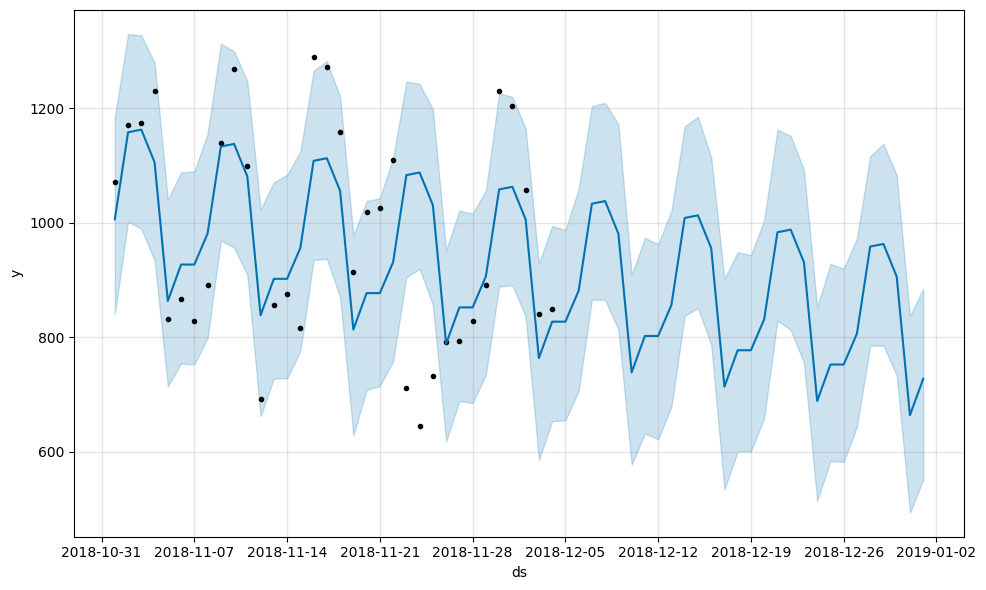

In [19]:
# Get the pickup location for the best model
sample_unique_id = final_df.index[0]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_unique_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_unique_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Prophet .fit() performs inference + prediction.
# Arima train only performs inference; prediction is an extra step.
if sample_algorithm == "arima":
    prediction = (
        sample_model.forecast(2 * (FORECAST_LENGTH + 1))
        .reset_index()
        .set_index("ds")
    )
    prediction["trend"] = None
    prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
    prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_unique_id]].error.values[0]
print(
    f"location {sample_unique_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["y", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 162, algorithm prophet_additive, best error 1254.3968101911753
(scheduler +9m45s) Failed to launch 1 node(s) of type worker-node-type-0.


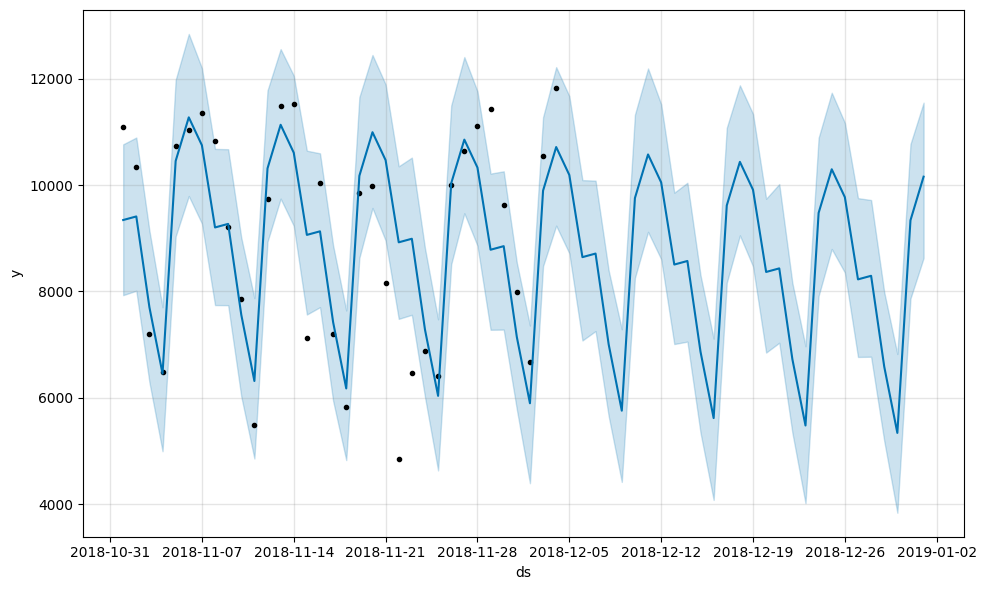

In [20]:
# Get the pickup location for the worst model
sample_unique_id = final_df.index[len(final_df) - 1]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_unique_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_unique_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Prophet .fit() performs inference + prediction.
# Arima train only performs inference; prediction is an extra step.
if sample_algorithm == "arima":
    prediction = (
        sample_model.forecast(2 * (FORECAST_LENGTH + 1))
        .reset_index()
        .set_index("ds")
    )
    prediction["trend"] = None
    prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
    prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]
# forecast_df = forecast_df.loc[(forecast_df.ds >= MIN_DATE), :]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_unique_id]].error.values[0]
print(
    f"location {sample_unique_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["y", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

## Deploy a model from checkpoint using Ray Serve <a class="anchor" id="serve_air"></a>

Coding steps for Deployment:
- **Step 1**. Instantiate a batch predictor using Ray AIR checkpoints.
- **Step 2**.  Create some test data.
- **Step 3**.  Define a Ray Serve deployment class by using a Ray decorator @serve.deployment.
- **Step 4**.  Deploy the model.
- **Step 5**.  Query the deployment and get the result.

For more details see [Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) and [Ray Serve](https://docs.ray.io/en/latest/serve/getting_started.html) docs.

In [ ]:
from ray import train, serve

In [21]:
# Get location to saved model.
# print(f"checkpoint: {checkpoint}")
# print(f"type model: {type(sample_model)}")
best_model = sample_model

##########
# STEP 1. Instantiate a batch predictor from checkpoint.
##########

# TODO: getting error this does not exist !?
# https://github.com/ray-project/ray/blob/8b98b51e4fb127a7ea2449b4def84d77e4e02f83/python/ray/train/batch_predictor.py
# predictor = ray.train.batch_predictor.BatchPredictor(
#     checkpoint=checkpoint,
#     predictor_cls=type(best_model),
#     preprocessor=BatchMapper(prepare_data_per_uniqueid, batch_format="pandas"),
# )

# Use native predictor instead
predictor = checkpoint.to_dict()["model"]

print(f"Batch predictor type: {type(predictor)}")

Batch predictor type: <class 'prophet.forecaster.Prophet'>


In [22]:
##########
# STEP 2. Create some test data. 
##########
# Restore validation data from checkpoint.
valid_df = checkpoint.to_dict()['valid_df']

# Being lazy, use validation data as test data
test_df = valid_df.copy()
test_df["ds"] = test_df["ds"] + timedelta(days=FORECAST_LENGTH)

In [23]:
##########
# STEP 3. Define a Ray Serve deployment class.
##########
@serve.deployment
class ProphetPredictor:
    def __init__(self, model, valid_data, test_data, forecast_length, unique_id):
        self.model = model
        self.valid_data = valid_data
        self.test_data = test_data
        self.forecast_length = forecast_length
        self.unique_id = unique_id
        
    def predict(self):
        future_dates = self.model.make_future_dataframe(
            periods=self.forecast_length, freq="D"
        )
        raw_predictions = \
          self.model.predict(future_dates)
        return raw_predictions
    
    def post_process(self, predictions):
        predictions = \
            pd.merge(predictions, self.valid_data[['ds', 'y']], 
                     on=['ds'], how='left')
        predictions = \
            pd.merge(predictions, self.test_data[['ds', 'y']], 
                     on=['ds'], how='left')
        predictions['y'] = predictions.y_x.combine_first(predictions.y_y)
        predictions.drop(['y_x', 'y_y'], inplace=True, axis=1)
        predictions['unique_id'] = self.unique_id
        return predictions
    
    def calc_error(self, future):
        temp = future.copy()
        temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
        temp.dropna(inplace=True)
        error = np.mean(temp["forecast_error"])
        return error

    def __call__(self):
        raw_predictions = self.predict()
        predictions = self.post_process(raw_predictions)
        error = self.calc_error(predictions)
        return [error, predictions]
    

In [24]:
##########
# STEP 4. Deploy the model.
##########
# Bind arguments to the Class constructor.
my_first_deployment = ProphetPredictor.bind(
    model=best_model,
    valid_data=valid_df, 
    test_data=test_df, 
    forecast_length=FORECAST_LENGTH,
    unique_id=sample_unique_id)

##########
# STEP 5. Query the deployment and get the result.
##########
# Get handle from serve.run().
handle = serve.run(my_first_deployment)

# Get ray results from the handle with ray.get().
ray_return = ray.get(handle.remote())
error = ray_return[0]
new_pred = ray_return[1]

print(type(error), type(new_pred))

INFO:/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/api.py:Connecting to existing Serve app in namespace "serve". New http options will not be applied.
INFO:/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/client.py:Updating deployment 'ProphetPredictor'. component=serve deployment=ProphetPredictor


(scheduler +9m51s) Failed to launch 1 node(s) of type worker-node-type-0.


INFO:/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/client.py:Deployment 'ProphetPredictor' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ProphetPredictor


<class 'numpy.float64'> <class 'pandas.core.frame.DataFrame'>


Forecast for location=162, error=1659.3306013811543


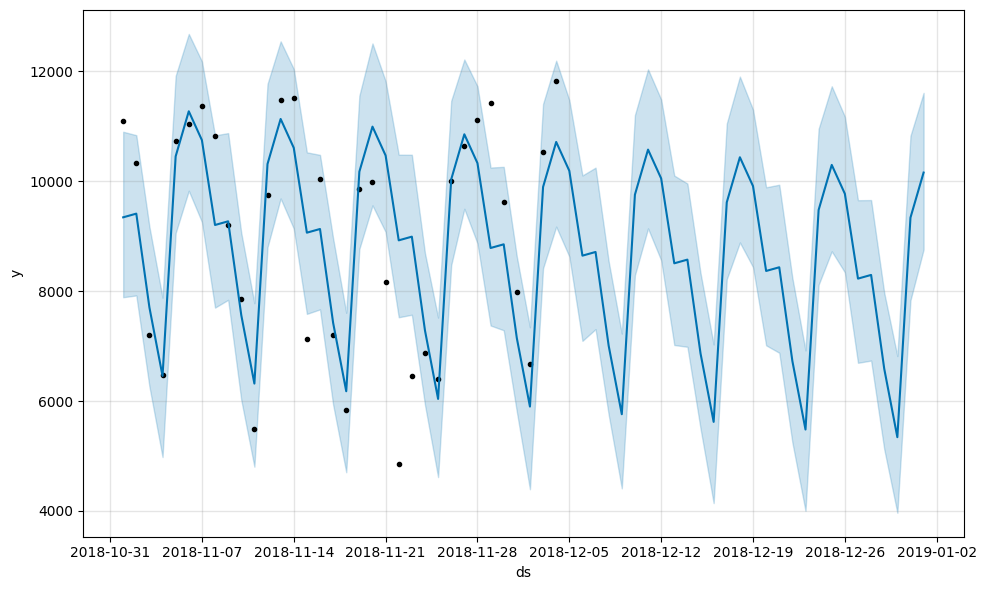

(scheduler +9m56s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m3s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m8s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m14s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m19s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m24s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m31s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m36s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m42s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m47s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m54s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +10m58s) Failed to launch 1 node(s) of type worker-node-type-0.


In [25]:
# Plot predictions from deployed model.
print(f"Forecast for location={sample_unique_id}, error={error}")
plot1 = best_model.plot(new_pred)